# Ensemble Network
In this notebook we show our solution for finding the best ensemble networks using the models obtained during the pretrained analysis.


## Load the dataset from Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow import keras

from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [2]:
from sklearn import metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Creating the validation dataset and the test dataset 

In [4]:
val_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/validation.csv')
y_val = val_questions['is_duplicate'].values
del val_questions

test_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/test.csv')
y_test = test_questions['is_duplicate'].values
del test_questions

In [5]:
x_val = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/validation/full_question_distilroberta.npy')
x_test = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/test/full_question_distilroberta.npy')

In [6]:
BATCH_SIZE = 128

In [7]:
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [8]:
del x_val
del y_val

In [9]:
import gc
gc.collect()

83

## The Ensemble classes
Before the ensemble class we need to define the models we have intention to use:

In [10]:
distilalbert_models = [
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving2.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving2_weighted.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving4.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_halving4_weighted.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace128.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace128_weighted.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace256.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace256_weighted.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace512.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace512_weighted.h5',
                       '/content/drive/MyDrive/Quora/Models/Transfer Learning/distilroberta_DL_pace64.h5'
                       ]

We also import some packages needed:

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
import random
import string

### DistilAlBERTa Ensemble class
Then we can define the ensemble class as follow:

In [12]:
FEATURE_DIMENSION = 1536

In [13]:
class EnsembleDistilAlBERTa:
    def __init__(self, val_ds):
        self.val_ds = val_ds

        # create list of models
        self.model_list = []

        for name in distilalbert_models:
            tmp = ks.models.load_model(name)
            tmp._name = name
            for i, layer in enumerate(tmp.layers):
                layer.trainable = False
                layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name
            self.model_list.append(tmp)


    def ensembleModel(self, active_models):
        loss = 'binary_crossentropy'

        models = [] # activated
        for i, model in enumerate(self.model_list):
            if active_models[i] == 1: # is active
                model._name = str(i)
                models.append(model)
        model_input = ks.Input(shape=(FEATURE_DIMENSION,))
        model_outputs = [model(model_input) for model in models]
        ensemble_output = ks.layers.Average()(model_outputs)
        ensemble_model = ks.Model(inputs=model_input, outputs=ensemble_output)
        ensemble_model.compile(loss=loss, metrics=['accuracy'])
        return ensemble_model

    def evaluate(self, ensemble_model):
        loss, acc = ensemble_model.evaluate(self.val_ds)
        return acc

    def ensemble_and_evaluate(self, active_models):
        if np.sum(active_models) == 0:
            return 0.0
        elif np.sum(active_models) == 1:
            print(active_models.index(1))
            return self.evaluate(self.model_list[active_models.index(1)])
        else:
            return self.evaluate(self.ensembleModel(active_models))

    def models_len(self):
        return len(self.model_list)
    
    def evaluate_test_set(self, active_models, X_test, y_test):
        if np.sum(active_models) == 0:
            print('No model selected')
        elif np.sum(active_models) == 1:
            print('Select two or more models')        
        '''else:
            return self.evaluate(self.ensembleModel(active_models))'''
        model = self.ensembleModel(active_models)
        y_score = model.predict(X_test)
        y_pred = np.rint(y_score) # to have 0 or 1
        y_true = y_test
        print("Classification report: ")
        print(metrics.classification_report(y_true,y_pred,digits = 4))
        metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

        # ROC curve
        fpr,tpr,th = metrics.roc_curve(y_true,y_score)
        roc_auc = metrics.roc_auc_score(y_true,y_score)

        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

In [19]:
def evaluate_test_set(model, X_test, y_test):
    y_score = model.predict(X_test)
    y_pred = np.rint(y_score) # to have 0 or 1
    y_true = y_test
    print("Classification report: ")
    print(metrics.classification_report(y_true,y_pred,digits = 4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

    # ROC curve
    fpr,tpr,th = metrics.roc_curve(y_true,y_score)
    roc_auc = metrics.roc_auc_score(y_true,y_score)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

### Genetic Algorithm Workflow 

In this section we use the ensemble class in order to find the best ensemble method using the precomputed models.
The first step is to download *Deap*

In [ ]:
!pip install deap

     |████████████████████████████████| 160 kB 8.2 MB/s 


Then we import all we need to use it 

In [ ]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Next step is to define the problem (we also save the number of the models)

In [14]:
ensemble = EnsembleDistilAlBERTa(val_ds)
INDIVIDUAL_LENGTH = ensemble.models_len()

In [15]:
INDIVIDUAL_LENGTH

11

We define the Genetic Algorithm constants:

In [ ]:
POPULATION_SIZE = 100
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 10
HALL_OF_FAME_SIZE = 5

We set the random seed:

In [ ]:
RANDOM_SEED = 42 
random.seed(RANDOM_SEED)

We create the toolbox:

In [ ]:
toolbox = base.Toolbox()

Then we define the functions for creating the population:

In [ ]:
# create an operator that randomly returns 0 or 1
toolbox.register('zeroOrOne', random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create('Individual', list, fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register('individualCreator', tools.initRepeat, creator.Individual, toolbox.zeroOrOne, INDIVIDUAL_LENGTH)

# create the population operator to generate a list of individual
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

We define the fitness:

In [ ]:
def ensembleAccuracy(individual):
    return ensemble.ensemble_and_evaluate(individual),

toolbox.register('evaluate', ensembleAccuracy)

Now, we can define the genetic operators:


*   Selection: tournament selection
*   Crossover: two point crossover
*  Mutation: multiple flip bit



In [ ]:
# Tournament selection with tournament size of 2:
toolbox.register("select", tools.selTournament, tournsize=2)

# Single-point crossover:
toolbox.register("mate", tools.cxTwoPoint)

# flip-bit mutation:
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/INDIVIDUAL_LENGTH)

### Genetic Algorithm flow:

Define the elitism flow function:

In [ ]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

Flow:

316/316 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 0.8708
8
316/316 [==============================] - 2s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8678
6
316/316 [==============================] - 4s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8733
10
316/316 [==============================] - 2s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8711
3
316/316 [==============================] - 3s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8717
gen	nevals	max     	avg     
0  	100   	0.873281	0.870271
316/316 [==============================] - 3s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8727
1  	88    	0.873281	0.871555
316/316 [==============================] - 3s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8712
2  	79    	0.873281	0.872069
316/316 [==============================] - 4s 9ms/step - loss: 0.0000e+00 - accuracy: 0.8725
3  	86    	0.873281	0.872331
316/316 [==============================] - 4s 10ms/step - loss: 0.0000e+00 - accuracy: 0.8728
4  	86  

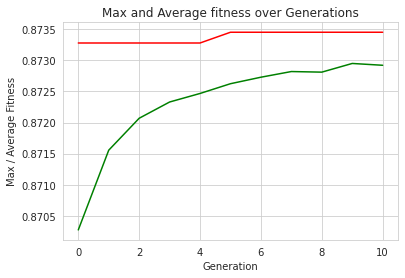

In [ ]:
# create initial population (generation 0):
population  = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best solution found:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

# extract statistics:
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

# plot statistics:
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.show()

In [ ]:
hof.items

[[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1],
 [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
 [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1],
 [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]]

Test on testset: CAMBIARE CON FUNZIONI NUOVE

Classification report: 
              precision    recall  f1-score   support

           0     0.9025    0.8876    0.8950     25348
           1     0.8162    0.8387    0.8273     15080

    accuracy                         0.8694     40428
   macro avg     0.8593    0.8632    0.8611     40428
weighted avg     0.8703    0.8694    0.8697     40428



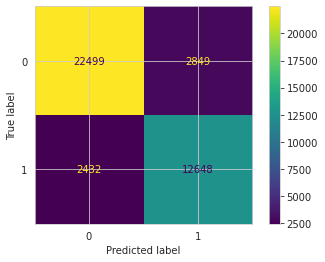

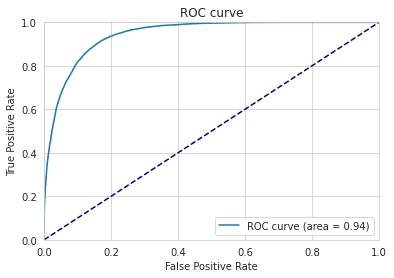

In [ ]:
ensemble = EnsembleDistilAlBERTa(None)
ensemble.evaluate_test_set(hof[0], x_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0     0.9054    0.8849    0.8950     25348
           1     0.8136    0.8446    0.8288     15080

    accuracy                         0.8699     40428
   macro avg     0.8595    0.8647    0.8619     40428
weighted avg     0.8712    0.8699    0.8703     40428



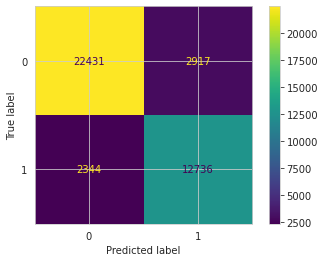

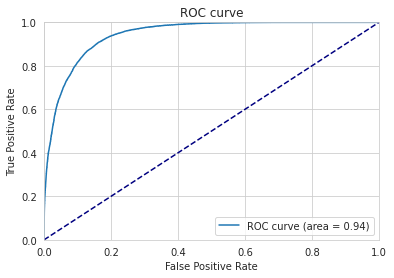

In [ ]:
ensemble.evaluate_test_set(hof[1], x_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0     0.9035    0.8878    0.8956     25348
           1     0.8168    0.8406    0.8285     15080

    accuracy                         0.8702     40428
   macro avg     0.8601    0.8642    0.8621     40428
weighted avg     0.8712    0.8702    0.8706     40428



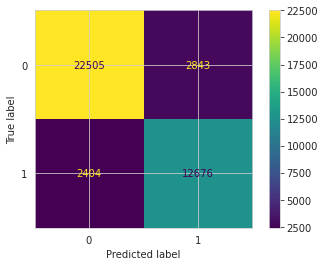

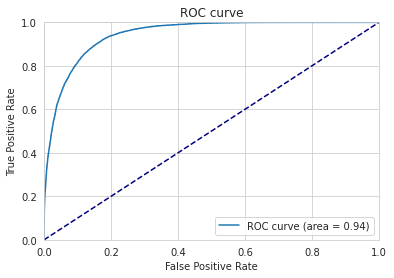

In [ ]:
ensemble.evaluate_test_set(hof[2], x_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0     0.9031    0.8884    0.8957     25348
           1     0.8174    0.8399    0.8285     15080

    accuracy                         0.8703     40428
   macro avg     0.8603    0.8641    0.8621     40428
weighted avg     0.8711    0.8703    0.8706     40428



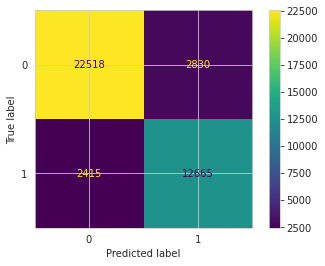

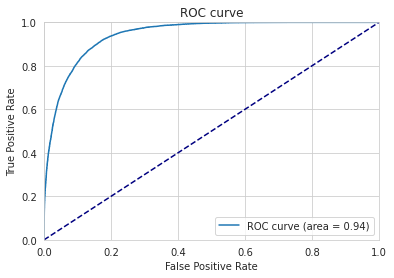

In [ ]:
ensemble.evaluate_test_set(hof[3], x_test, y_test)

Classification report: 
              precision    recall  f1-score   support

           0     0.9053    0.8848    0.8949     25348
           1     0.8134    0.8444    0.8286     15080

    accuracy                         0.8697     40428
   macro avg     0.8593    0.8646    0.8617     40428
weighted avg     0.8710    0.8697    0.8702     40428



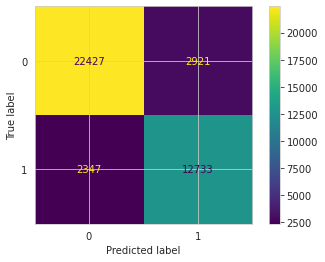

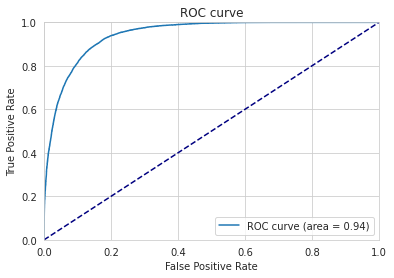

In [ ]:
ensemble.evaluate_test_set(hof[4], x_test, y_test)

# Plot best without grid

In [17]:
copy = ensemble.ensembleModel([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])

Classification report: 
              precision    recall  f1-score   support

           0     0.9035    0.8878    0.8956     25348
           1     0.8168    0.8406    0.8285     15080

    accuracy                         0.8702     40428
   macro avg     0.8601    0.8642    0.8621     40428
weighted avg     0.8712    0.8702    0.8706     40428



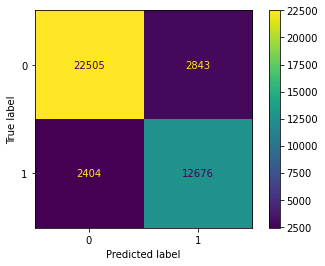

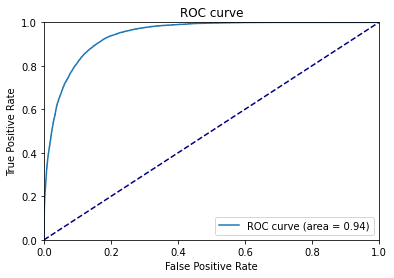

In [20]:
evaluate_test_set(copy, x_test, y_test)

## Save predictions

In [ ]:
copy = ensemble.ensembleModel([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])

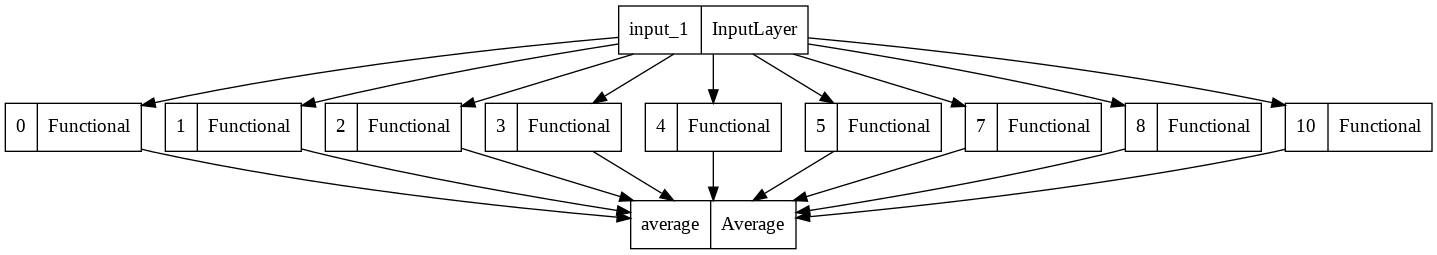

In [ ]:
ks.utils.plot_model(copy)

In [ ]:
predicted_test = copy.predict(x_test)

In [ ]:
predicted_test

array([[0.98151284],
       [0.7781903 ],
       [0.03140078],
       ...,
       [0.6055129 ],
       [0.06935241],
       [0.49692774]], dtype=float32)

In [ ]:
np.save('/content/drive/MyDrive/Quora/Predictions/predicted_test.npy', predicted_test)

In [ ]:
x_val = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/validation/full_question_distilroberta.npy')
predicted_val = copy.predict(x_val)
predicted_val

array([[0.00143591],
       [0.8004187 ],
       [0.78254575],
       ...,
       [0.14644428],
       [0.3253738 ],
       [0.00099263]], dtype=float32)

In [ ]:
np.save('/content/drive/MyDrive/Quora/Predictions/predicted_val.npy', predicted_val)

## Validation metrics

In [ ]:
copy = ensemble.ensembleModel([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])

In [ ]:
copy.evaluate(val_ds)

316/316 [==============================] - 13s 18ms/step - loss: 0.2859 - accuracy: 0.8733


[0.285889595746994, 0.87330561876297]

## Training metrics

In [ ]:
x_train = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/training/full_question_distilroberta.npy')

train_questions = pd.read_csv('/content/drive/MyDrive/Quora/Dataset/training.csv')
y_train = train_questions['is_duplicate'].values
del train_questions

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
del x_train
gc.collect()

1484

In [ ]:
copy.evaluate(train_ds)

2527/2527 [==============================] - 48s 18ms/step - loss: 0.2005 - accuracy: 0.9229


[0.20048373937606812, 0.9229387640953064]